# Setup

In [22]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
%pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
%pip install langdetect
%pip install tqdm

  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to c:\users\xylos\appdata\local\temp\pip-req-build-9r2nwlbj
  Resolved https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to commit bc0ebd0135a6cc78f48ddf184069b4c0b9c017d8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git 'C:\Users\Xylos\AppData\Local\Temp\pip-req-build-9r2nwlbj'


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time
import nltk
from nltk.corpus import stopwords
# from nltk.stem import French
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer # package for french lemmatization
from nltk.tokenize.treebank import TreebankWordDetokenizer
import random
import re

from nltk.corpus import wordnet
from langdetect import detect

from tqdm import tqdm

seed = 10
random.seed(seed)
np.random.seed(seed)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xylos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xylos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Xylos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Xylos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Get Data

In [3]:
#path = '/content/drive/MyDrive/Olympus in the Sky/McGill/2024 - Winter/ECSE 551/Data/'
path = 'Data/'
df = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
df = df.sample(frac=1, random_state=1).reset_index(drop = True)
df = df[~df['body'].str.contains('\?'*10)]

training_data = df['body'].apply(lambda x: x.lower().replace('_', ' ')).to_numpy()
training_labels = df['subreddit'].to_numpy()

## Preprocessing

In [4]:
def get_wordnet_pos(word):
  """Map POS tag to first character lemmatize() accepts"""
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def remove_stop_words(arr_of_words, stop_words):
  return [word for word in arr_of_words if word not in stop_words]

def lemmatize(arr_of_words):
  lang = detect(' '.join(arr_of_words))
  if lang == 'en':
      lemmatizer = WordNetLemmatizer()
  else:
      lemmatizer = FrenchLefffLemmatizer()

  return [lemmatizer.lemmatize(word, pos = get_wordnet_pos(word)) for word in arr_of_words]

def preprocess(sentences, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = None, is_lemmatize = False):
  new_sentence_list = []
  pattern = regex_pattern

  for iter, sentence in enumerate(sentences):

      words = list(set(re.findall(pattern, sentence)))
      if stop_words:
        words = remove_stop_words(words, stop_words)

      if is_lemmatize:
        words = lemmatize(words)

      new_sentence_list.append(' '.join(words))

  return np.array(new_sentence_list)

# Support Vector Machine

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import svm 

# X_train = [
#     "I love this movie",
#     "This movie is great",
#     "A movie like this is great",
#     "I hate this movie",
#     "This movie is terrible"]

# y_train = [1, 1, 1, 0, 0]  # 1 for positive sentiment, 0 for negative sentiment

# spacy_stopwords_list = list(fr_stop) + list(en_stop)
# nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
# other_stop_words = ['http', 'https', 'www']
# stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

# token_pattern = r"(?u)\b[a-z][a-z]+\b"

# tf_idf_vectorizer = TfidfVectorizer(binary = True, stop_words= stop_words, token_pattern = token_pattern, ngram_range = (1,1))
# vectors_train_idf = tf_idf_vectorizer.fit_transform(X_train)

# classifier = svm.SVC(kernel='linear')

# classifier.fit(vectors_train_idf, y_train)

# X_test = [
#     "I love this movie terrible", # Example of both class being viable but the second being chosen due to label eval order in NB
#     "I hate this great movie",
#     "This movie is terrible"]

# Y_test = [1, 1, 0]

# test_transformed = tf_idf_vectorizer.transform(X_test)

# y_pred = classifier.predict(test_transformed)

# print("Accuracy:",accuracy_score(Y_test, y_pred))

class SVM(): 
    def __init__(self, max_features = 3000, token_pattern = r"(?u)\b[a-z][a-z]+\b", min_df = 1, max_df = 1.0, ngram_range = (1,1)):
        spacy_stopwords_list = list(fr_stop) + list(en_stop)
        nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
        self.pattern = token_pattern
        self.ngram_range = ngram_range
        self.vectorizer = TfidfVectorizer(binary = True, max_features = max_features, token_pattern = self.pattern, min_df = min_df, max_df = max_df, ngram_range = ngram_range)
        self.svm_class = svm.SVC(kernel='linear')

    def train(self, x_data_train, x_data_labels):
        assert len(x_data_train)  == len(x_data_labels)
        # assert type(x_data_train) == type(x_data_labels) == np.ndarray
        # fit the 
        vectors_train_idf = self.vectorizer.fit_transform(x_data_train).todense()
        self.svm_class.fit(vectors_train_idf, x_data_labels)
    
    def predict(self, x_data_test): 
        tfidf_test = self.vectorizer.transform(x_data_test)
        x_data_pred = self.svm_class.predict(tfidf_test)
        return x_data_pred


X_train = [
    "I love this movie",
    "This movie is great",
    "A movie like this is great",
    "I hate this movie",
    "This movie is terrible"]

y_train = [1, 1, 1, 0, 0]  # 1 for positive sentiment, 0 for negative sentiment

model = SVM()
model.train(X_train, y_train)

X_test = [
    "I love this movie terrible", # Example of both class being viable but the second being chosen due to label eval order in NB
    "I hate this great movie",
    "This movie is terrible"]

Y_test = [1, 1, 0]


y_pred = model.predict(X_test)

print("Accuracy:",accuracy_score(Y_test, y_pred))

        

TypeError: np.matrix is not supported. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

# Random Forest

# NB and K-Fold

In [ ]:
# to find P(Y=k), just do test_labels.where(k)/len(test_labels)
# vectos_train will contain all the information I need to create the counting for each word
# use the get_feature_names to create a dictionary to map to all counts
# this dictionary would be contained in another dict that has the labels as keys
# to find P(xj,k), find the indices where test_labels = (k), then find

In [6]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

class LemmaTokenizer:
     def __init__(self, pattern):
       self.pattern = pattern
     def __call__(self, doc):
       doc = doc.lower().replace('_', ' ')
       doc_words = list(set(re.findall(self.pattern, doc)))
       lang = detect(' '.join(doc_words))
       if lang == 'en':
           lemmatizer = WordNetLemmatizer()
       else:
           lemmatizer = FrenchLefffLemmatizer()
       return [lemmatizer.lemmatize(word,pos =get_wordnet_pos(word)) for word in doc_words]

In [7]:
class NB():
  def __init__(self, max_features = 3000, token_pattern = r"(?u)\b[a-z][a-z]+\b", min_df = 1, max_df = 1.0, ngram_range = (1,1)):
    spacy_stopwords_list = list(fr_stop) + list(en_stop)
    nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
    self.pattern = token_pattern
    self.ngram_range = ngram_range
    self.vectorizer = CountVectorizer(binary = True, max_features = max_features, token_pattern = self.pattern, min_df = min_df, max_df = max_df, ngram_range = ngram_range)
    self.no_pred = []

  # currently train_corpus expects a np array containing a list of strings, not array of words, nxm
  # test_label is an nx1 array
  def train(self, train_corpus, test_labels):
    assert len(train_corpus)  == len(test_labels)
    assert type(train_corpus) == type(test_labels) == np.ndarray

    vectors_train       = self.vectorizer.fit_transform(train_corpus).todense()
    self.analyzer       = self.vectorizer.build_analyzer()
    self.word_list      = self.vectorizer.get_feature_names_out()
    self.num_samples    = len(test_labels)
    self.word_count     = dict(zip(self.word_list, np.array(vectors_train.sum(axis=0))[0]))

    unique, counts   = np.unique(test_labels, return_counts=True)
    self.label_count = dict(zip(unique, counts))
    self.labels      = unique

    self.word_count_given_label = {}
    for label in self.labels:
      indices = np.where(test_labels == label)[0]
      tot_word_count = np.array(vectors_train[indices].sum(axis=0))[0]
      self.word_count_given_label[label] = {self.word_list[i] : tot_word_count[i] for i in range(len(tot_word_count))}
      # print(label, self.word_count_given_label[label])

  # Assuming test_corpus is 2-d array where each test sample is a string
  def predict(self, test_corpus):

    predictions = []
    for corpus in tqdm(test_corpus, desc="Loading…", ascii=False, ncols=75):

      best_label = ''
      best_prob  = -np.inf

      corpus_words = self.analyzer(corpus)

      for label in self.labels:
        p_of_y = self.label_count[label]/self.num_samples

        p_of_x_given_y = 1

        for word in self.word_list:
          if word in corpus_words:
            xj = 1
          else:
            xj = 0

          theta_xj_k      = (self.word_count_given_label[label][word] + 1) / (self.label_count[label] + len(self.labels))
          p_of_x_given_y *= (theta_xj_k**(xj) * (1-theta_xj_k)**(1-xj))
          # print(label, word, p_of_x_given_y, theta_xj_k, (theta_xj_k**(xj) * (1-theta_xj_k)**(1-xj)))

        unseen_words = [new_word for new_word in corpus_words if new_word not in self.word_list]
        for word in unseen_words:
          # p_of_x_given_y *= 1/(self.label_count[label] + len(self.labels))
          p_of_x_given_y *= 1/(len(self.labels)) # When there are a large number of unseen words, the p_of_x_given_y basically becomes 0
        # print(len(unseen_words), len(corpus_words))

        p_of_y_given_x = np.log(p_of_y * p_of_x_given_y)
        # print(p_of_y, p_of_x_given_y)
        # print(label, p_of_y_given_x)

        # print(p_of_y_given_x, best_prob)
        if p_of_y_given_x > best_prob:
          best_prob = p_of_y_given_x
          best_label = label

      if p_of_x_given_y == 0:
        self.no_pred.append(corpus)
      #   best_label = random.choice(self.labels)

      predictions.append(best_label)

    return predictions

In [8]:
def k_fold_validation(x_train_data, y_train_data, K = 10):
  assert type(x_train_data) == np.ndarray and type(y_train_data) == np.ndarray

  len_of_data  = len(x_train_data) - len(x_train_data) % K
  data_x       = x_train_data[:len_of_data]
  data_y       = y_train_data[:len_of_data]
  size_of_fold = len(x_train_data[:len_of_data]) // K
  validation_error = 0

  error    = []
  pred     = []
  timings  = []
  no_preds = []

  naive_bayes = NB()

  for i in range(K):

    naive_bayes = NB()

    if i != K-1:
      validation_fold_x = data_x[i*size_of_fold:(i+1)*size_of_fold]
      validation_fold_y = data_y[i*size_of_fold:(i+1)*size_of_fold]

      training_folds_x  = np.concatenate((data_x[:i*size_of_fold], data_x[(i+1)*size_of_fold:]))
      training_folds_y  = np.concatenate((data_y[:i*size_of_fold], data_y[(i+1)*size_of_fold:]))

    else:
      validation_fold_x = data_x[i*size_of_fold:]
      validation_fold_y = data_y[i*size_of_fold:]

      training_folds_x  = data_x[:i*size_of_fold]
      training_folds_y  = data_y[:i*size_of_fold]

    start_time = time.time()
    naive_bayes.train(training_folds_x, training_folds_y)
    end_time = time.time()

    timings.append(end_time - start_time)

    pred_valid = naive_bayes.predict(validation_fold_x)
    no_pred = naive_bayes.no_pred
    # pred_train = naive_bayes.predict(training_folds_x)

    fold_error = {}
    fold_error['validation'] = 1 - accuracy_score(pred_valid, validation_fold_y)
    validation_error        += 1 - accuracy_score(pred_valid, validation_fold_y)
    # fold_error['train']      = 1 - accuracy_score(pred_train, training_folds_y)

    model_pred = {}
    model_pred['validation'] = (pred_valid, validation_fold_y)
    # model_pred['train']      = (pred_train, training_folds_y )

    error.append(fold_error)
    pred.append(model_pred)
    no_preds.append(no_pred)

  info = {'error': error, 'pred': pred, 'time': timings, 'no_preds' : no_preds}

  return validation_error/K, info

# Simple test cases for NB

In [9]:
train_corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
     'Is this the first document?',]
test_labels = np.array(['1', '2', '3', '4'])
train_corpus = np.array(train_corpus)
test_corpus = ['harro first pink haha']
model = NB()
model.train(train_corpus, test_labels)
model.predict(test_corpus)

Loading…: 100%|█████████████████████████████| 1/1 [00:00<00:00, 499.32it/s]


['1']

In [10]:
# Training data
X_train = np.array([
    "I love this movie",
    "This movie is great",
    "A movie like this is great",
    "I hate this movie",
    "This movie is terrible"])

# Corresponding labels
y_train = np.array([1, 1, 1, 0, 0])  # 1 for positive sentiment, 0 for negative sentiment

model = NB()
model.train(X_train, y_train)
X_test = [
    "I love this movie terrible", # Example of both class being viable but the second being chosen due to label eval order in NB
    "I hate this great movie",
    "This movie is terrible"]

print(model.predict(X_test))

Loading…: 100%|████████████████████████████| 3/3 [00:00<00:00, 2986.69it/s]

[0, 1, 0]


# K-fold for NB

In [ ]:
# TODO: No predictions given, divide by zero warnings might be the cause (Solved?)
# TODO: Test changing the prob caluclation to be a sum of logs

In [ ]:
# No preprocessing
test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(training_data, training_labels,  test_size = int(len(training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))
print()
print(model.no_pred)

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print('Mean Error: {}'.format(mean_error))

In [ ]:
# With Processing
spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

processed_training_data = preprocess(training_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = stop_words, is_lemmatize = False)

test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels,  test_size = int(len(processed_training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print()
print('Mean Error: {}'.format(mean_error))
print()
print('\nModel Misses: {}'.format(model.no_pred))

In [ ]:
# With Processing
# lemmatized_data = preprocess(training_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = None, is_lemmatize = True)
spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words('english') + stopwords.words('french')
other_stop_words = ['http', 'https', 'www']
stop_words = list(set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words))

processed_training_data = preprocess(lemmatized_data, regex_pattern = r"(?u)\b[a-z][a-z]+\b", stop_words = stop_words, is_lemmatize = False)

test_split = 0.1

(training_data_split, testing_data_split, training_labels_split, testing_labels_split) = train_test_split(processed_training_data, training_labels,  test_size = int(len(processed_training_data)*test_split), random_state=seed)

model = NB()
model.train(training_data_split, training_labels_split)
pred = model.predict(testing_data_split)
print((pred == testing_labels_split).sum()/len(testing_labels_split))

mean_error, info = k_fold_validation(training_data_split, training_labels_split)
print()
print('Mean Error: {}'.format(mean_error))
print()
print('\nModel Misses: {}'.format(model.no_pred))

In [ ]:
sorted(model.word_count.items(), key=lambda item: item[1], reverse = True)[:-1]

# Experimentation

## Aydin Exploration

In [123]:
# Imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from langdetect import detect, DetectorFactory

### Data prep

In [140]:
# set to true to split dataset into english and french
split_en_fr = True

DetectorFactory.seed = 0
language = np.empty(np.shape(training_data), dtype=np.dtype("U2"))
if split_en_fr:
    for i,sample in enumerate(training_data):
        language[i] = detect(sample)
training_data_en = np.delete(training_data, language == "fr")
training_labels_en = np.delete(training_labels, language == "fr")
training_data_fr = np.delete(training_data, language == "en")
training_labels_fr = np.delete(training_labels, language == "en")

In [170]:
# Define data. Set to True to use actual dataset False for custom data
# Set use_fr_en to True to partition the data into en and fr sample 
use_fr_en = False
use_en = False
use_Dataset = True
if use_Dataset:
    if use_fr_en:
        if use_en:
            X_train, X_val, Y_train, Y_val = train_test_split(training_data_en, training_labels_en, test_size=0.2, random_state=seed)
        else:
            X_train, X_val, Y_train, Y_val = train_test_split(training_data_fr, training_labels_fr, test_size=0.2, random_state=seed)
    else:
        X_train, X_val, Y_train, Y_val = train_test_split(training_data, training_labels, test_size=0.2, random_state=seed)
else:
    X_train = [
        "I love this movie",
        "This movie is great",
        "A movie like this is great",
        "I hate this movie",
        "This movie is terrible",
    ]

    Y_train = [1, 1, 1, 0, 0]  # 1 for positive sentiment, 0 for negative sentiment

    X_val = [
        "I love this movie terrible",  # Example of both class being viable but the second being chosen due to label eval order in NB
        "I hate this great movie",
        "This movie is terrible",
    ]

    Y_val = [1, 1, 0]

In [6]:
# Define Stopwords
spacy_stopwords_list = list(fr_stop) + list(en_stop)
nltk_stopwords_list = stopwords.words("english") + stopwords.words("french")
other_stop_words = ["http", "https", "www"]
stop_words = list(
    set().union(spacy_stopwords_list, nltk_stopwords_list, other_stop_words)
)

### Logistic Regression

In [158]:
# make pipeline
pipe = Pipeline(
    [("Vectorizer", TfidfVectorizer(
        stop_words=stop_words,
        token_pattern=r"(?u)\b[a-z][a-z]+\b",
        ngram_range=(1, 1),
        max_df=0.1,
        min_df=1,
        max_features=10000,
    )),
    ("Classifier", LogisticRegression(C=3, random_state=0, solver="lbfgs"))
    ]
)

In [159]:
# set hyperparams to search

# best params from large search (took ~15 minutes)
# {
#     "Classifier__C": 3,
#     "Vectorizer__max_df": 0.1,
#     "Vectorizer__max_features": 10000,
#     "Vectorizer__min_df": 1,
#     "Vectorizer__ngram_range": (1, 1),
# }

# "lbfgs", "liblinear", "newton-cg" are all good

# 69% accuracy

parameters = {
    # "Vectorizer__ngram_range": ((1,1), (1,2), (1,3), (1,4)),
    # "Vectorizer__max_df": (0.1, 1.0),
    # "Vectorizer__min_df": (1, 2, 10),
    # "Vectorizer__max_features": (3000, 5000, 7000, 10000),
    # "Classifier__C": (1, 3, 5, 10),
    # "Classifier__solver": ("lbfgs", "liblinear", "newton-cg", "sag")
}

# search params with gridsearch
gs = GridSearchCV(pipe, parameters)
gs.fit(X_train, Y_train)

c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(max_df=0.1,
                                                        max_features=10000,
                                                        stop_words=['ainsi',
                                                                    'egalement',
                                                                    "'re",
                                                                    "you've",
                                                                    'serai',
                                                                    'empty',
                                                                    'eurent',
                                                                    'again',
                                                                    'around',
                                                                    'dit',
                                                                    'pense',
                                                                    'toujours',
                                                                    'its',
                                                                    'certain',
                                                                    'avons',
                                                                    'often',
                                                                    'else',
                                                                    'then',
                                                                    'hereby',
                                                                    'quatrième',
                                                                    'within',
                                                                    'antérieure',
                                                                    'yourself',
                                                                    'http',
                                                                    'suivantes',
                                                                    '’s',
                                                                    'with',
                                                                    'side',
                                                                    'was',
                                                                    'theirs', ...],
                                                        token_pattern='(?u)\\b[a-z][a-z]+\\b')),
                                       ('Classifier',
                                        LogisticRegression(C=3,
                                                           random_state=0))]),
             param_grid={})

In [160]:
# Show best score and params
print(gs.score(X_val, Y_val))
print(gs.best_params_)
print(gs.cv_results_["mean_test_score"])

0.7123287671232876
{}
[0.77785844]


### Linear SVM

In [171]:
# make pipeline
pipe = Pipeline(
    [("Vectorizer",TfidfVectorizer(
        stop_words=stop_words,
        token_pattern=r"(?u)\b[a-z][a-z]+\b",
        ngram_range=(1, 2),
        max_df=0.1,
        min_df=1,
        max_features=10000,
    )),
    ("Classifier", svm.LinearSVC(dual=True, C=3, random_state=0)),]
)

In [172]:
# best params from small multi param searches
# {
#     "Vectorizer__ngram_range": (1, 2),
#     "Vectorizer__max_df": 0.1,
#     "Vectorizer__min_df": 1,
#     "Vectorizer_max_features": 10000,
#     "Classifier_dual": True,
#     "Classifier__C": 3,
#     "Classifier_tol": 1e-4,
# }

# 70% accuracy

parameters = {
    # "Vectorizer__ngram_range": ((1,1), (1,2), (1,3), (1,4)),
    # "Vectorizer__max_df": (0.1, 0.2, 0.9, 1.0),
    # "Vectorizer__min_df": (1, 2, 5, 10),
    # "Vectorizer__max_features": (3000, 5000, 7000, 9000, 10000, 20000),
    # "Classifier__dual": (True, False),
    # "Classifier__C": (0.4, 0.5, 0.6, 1, 3, 5),
    # "Classifier__tol": (1e-3, 1e-4, 1e-5),
}

# search params with gridsearch
gs = GridSearchCV(pipe, parameters)
gs.fit(X_train, Y_train)

c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(max_df=0.1,
                                                        max_features=10000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['ainsi',
                                                                    'egalement',
                                                                    "'re",
                                                                    "you've",
                                                                    'serai',
                                                                    'empty',
                                                                    'eurent',
                                                                    'again',
                                                                    'around',
                                                                    'dit',
                                                                    'pense',
                                                                    'toujours',
                                                                    'its',
                                                                    'certain',
                                                                    'avons',
                                                                    'often',
                                                                    'else',
                                                                    'then',
                                                                    'hereby',
                                                                    'quatrième',
                                                                    'within',
                                                                    'antérieure',
                                                                    'yourself',
                                                                    'http',
                                                                    'suivantes',
                                                                    '’s',
                                                                    'with',
                                                                    'side',
                                                                    'was',
                                                                    'theirs', ...],
                                                        token_pattern='(?u)\\b[a-z][a-z]+\\b')),
                                       ('Classifier',
                                        LinearSVC(C=3, dual=True,
                                                  random_state=0))]),
             param_grid={})

In [173]:
# Show best score and params
print(gs.score(X_val, Y_val))
print(gs.best_params_)
print(gs.cv_results_["mean_test_score"])

0.7035714285714286
{}
[0.70594971]


### SVC

In [164]:
# make pipeline
pipe = Pipeline(
    [("Vectorizer",TfidfVectorizer(
        stop_words=stop_words,
        token_pattern=r"(?u)\b[a-z][a-z]+\b",
        ngram_range=(1, 2),
        max_df=0.1,
        min_df=1,
        max_features=20000,
    )),
    ("Classifier", svm.SVC(C=3, kernel="sigmoid", tol=1e-3, decision_function_shape="ovr", random_state=0))]
)

In [165]:
# {
#     "Vectorizer__ngram_range": (1, 2),
#     "Vectorizer__max_df": 0.1,
#     "Vectorizer__min_df": 1,
#     "Vectorizer__max_features": 20000,
#     "Classifier__C": 3,
#     "Classifier__kernel": "sigmoid",
# }

# 69% accuracy

parameters = {
    # "Vectorizer__ngram_range": ((1,1), (1,2)),
    # "Vectorizer__max_df": (0.1, 1.0),
    # "Vectorizer__min_df": (1, 2),
    # "Vectorizer__max_features": (5000, 10000, 20000),
    # "Classifier__C": (0.5, 1, 3, 5),
    # "Classifier__kernel": ("poly", "rbf", "sigmoid"),
    # "Classifier__degree": (2, 3, 4, 5, 6, 7),
    # "Classifier__tol": (1e-2, 1e-3, 1e-4, 1e-5),
    # "Classifier__decision_function_shape": ("ovr", "ovo"),
}

# search params with gridsearch
gs = GridSearchCV(pipe, parameters)
gs.fit(X_train, Y_train)

c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(max_df=0.1,
                                                        max_features=20000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['ainsi',
                                                                    'egalement',
                                                                    "'re",
                                                                    "you've",
                                                                    'serai',
                                                                    'empty',
                                                                    'eurent',
                                                                    'again',
                                                                    'around',
                                                                    'dit',
                                                                    'pense',
                                                                    'toujours',
                                                                    'its',
                                                                    'certain',
                                                                    'avons',
                                                                    'often',
                                                                    'else',
                                                                    'then',
                                                                    'hereby',
                                                                    'quatrième',
                                                                    'within',
                                                                    'antérieure',
                                                                    'yourself',
                                                                    'http',
                                                                    'suivantes',
                                                                    '’s',
                                                                    'with',
                                                                    'side',
                                                                    'was',
                                                                    'theirs', ...],
                                                        token_pattern='(?u)\\b[a-z][a-z]+\\b')),
                                       ('Classifier',
                                        SVC(C=3, kernel='sigmoid',
                                            random_state=0))]),
             param_grid={})

In [166]:
# Show best score and params
print(gs.score(X_val, Y_val))
print(gs.best_params_)
print(gs.cv_results_["mean_test_score"])

0.684931506849315
{}
[0.80562613]


### SGD

In [167]:
# make pipeline
pipe = Pipeline([
    ("Vectorizer",TfidfVectorizer(
        stop_words=stop_words,
        token_pattern=r"(?u)\b[a-z][a-z]+\b",
        ngram_range=(1, 2),
        max_df=0.2,
        min_df=1,
        max_features=20000,
    )),
    ("Classifier",SGDClassifier(
        loss="huber",
        alpha=0.00001,
        tol=1e-3,
        random_state=0,
    ))]
)

In [168]:
{
    "Vectorizer__ngram_range": (1, 2),
    "Vectorizer__max_df": 0.2,
    "Vectorizer__min_df": 1,
    "Vectorizer__max_features": 20000,
    "Classifier__loss": "huber",
    "Classifier__alpha": 0.00001,
    "Classifier__tol": 1e-3,
}

# 70% accuracy

parameters = {
    # "Vectorizer__ngram_range": ((1, 1), (1, 2)),
    # "Vectorizer__max_df": (0.1, 0.2, 0.3),
    # "Vectorizer__min_df": (1, 2),
    # "Vectorizer__max_features": (5000, 10000, 20000),
    # "Classifier__loss": ("hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber"),
    # "Classifier__alpha": (1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1),
    # "Classifier__tol": (1e-2, 1e-3, 1e-4, 1e-5),
}

# search params with gridsearch
gs = GridSearchCV(pipe, parameters)
gs.fit(X_train, Y_train)

c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(
c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(max_df=0.2,
                                                        max_features=20000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['ainsi',
                                                                    'egalement',
                                                                    "'re",
                                                                    "you've",
                                                                    'serai',
                                                                    'empty',
                                                                    'eurent',
                                                                    'again',
                                                                    'around',
                                                                    'dit',
                                                                    'pense',
                                                                    'toujours',
                                                                    'its',
                                                                    'certain',
                                                                    'avons',
                                                                    'often',
                                                                    'else',
                                                                    'then',
                                                                    'hereby',
                                                                    'quatrième',
                                                                    'within',
                                                                    'antérieure',
                                                                    'yourself',
                                                                    'http',
                                                                    'suivantes',
                                                                    '’s',
                                                                    'with',
                                                                    'side',
                                                                    'was',
                                                                    'theirs', ...],
                                                        token_pattern='(?u)\\b[a-z][a-z]+\\b')),
                                       ('Classifier',
                                        SGDClassifier(alpha=1e-05, loss='huber',
                                                      random_state=0))]),
             param_grid={})

In [169]:
# Show best score and params
print(gs.score(X_val, Y_val))
print(gs.best_params_)
print(gs.cv_results_["mean_test_score"])

0.7397260273972602
{}
[0.78136721]


### Plot results (broken)

In [34]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Extract results to plot into (n,m)
# n is number of parameters searched plus accuracy in last index
# m is size of all combinations of parameters ie p1*p2*p3...=m

# DOESNTWORK!! needs tweaking for the ngram tuple and only works for 2 params
debug=False

results = np.empty((len(parameters) + 1, len(gs.cv_results_["mean_test_score"])))
for i,param in enumerate(list(gs.cv_results_.keys())[4 : 4 + len(parameters)]):
    if debug:
        print(param)
        print(gs.cv_results_[param])
    results[i] = gs.cv_results_[param]
if debug:
    print("mean_test_score")
    print(gs.cv_results_["mean_test_score"])
results[len(parameters)] = gs.cv_results_["mean_test_score"]

In [137]:
line_num=len(list(parameters.items())[0][1])
slice_size=len(list(parameters.items())[1][1])

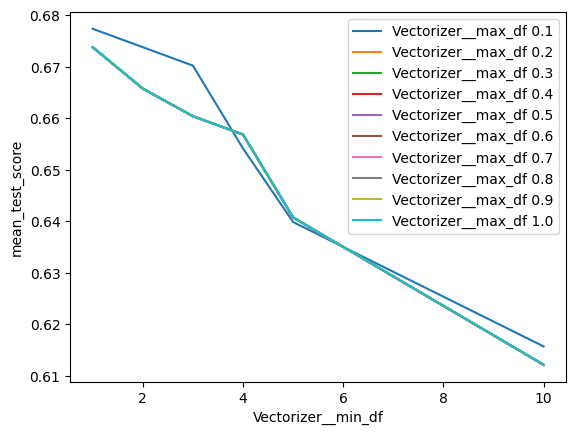

In [146]:
for i in range(line_num):
    plt.plot(results[1, i * slice_size : i * slice_size + slice_size], results[2, i * slice_size : i * slice_size + slice_size], label=list(parameters.items())[0][0]+" "+str(results[0,i*slice_size]))
plt.legend()
plt.xlabel(list(parameters.items())[1][0])
plt.ylabel("mean_test_score")
plt.show()

### Actual Test

In [174]:
# Get test data
path = "Data/"
test_df = pd.read_csv(path + "test.csv", encoding="ISO-8859-1")
test_data = test_df["body"].apply(lambda x: x.lower().replace("_", " ")).to_numpy()

In [175]:
# predict test labels
test_labels=pipe.fit(training_data, training_labels).predict(test_data)

c:\Users\Xylos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'quelqu'] not in stop_words.
  warnings.warn(


In [180]:
result=pd.DataFrame(test_labels)
result.to_csv("Data/submission.csv")

## Stop Words

## Lemmatization

## Max Features

# Actual Test Case

In [ ]:
model = NB()
model.train(processed_comment_data, labels)

test_df = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
test_data = test_df['body'].to_numpy()
processed_test_data = lemmatize_and_remove_stop_words(test_data)

predictions = model.predict(processed_test_data)

In [ ]:
pd.DataFrame({'Subreddit':predictions}).reset_index().rename(columns={"index": "Id"}).to_csv('results.csv', index=False)